In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
i,j = np.meshgrid(np.arange(-5,6,1), np.arange(-5,6,1), indexing='ij')

In [3]:
def gen_val(extent):
    val = np.random.randint(-extent,extent+1)
    return(val)

def gen_step(extent=1):
    step = np.array([gen_val(extent),gen_val(extent),gen_val(extent)])
    return(step)
    

In [4]:
def random_walk(lims=[-5,5,-5,5,-5,5],init_pos=np.array([0,0,0]),nsteps=10,extent=1):
    
    positions = np.zeros((nsteps,3))
    positions[0]=init_pos
    
    for i in np.arange(nsteps-1):
        flag = 1
        while flag==1:
            step = gen_step(extent)
            positions[i+1]=positions[i]+step
            if (lims[0]<=positions[i+1][0]<=lims[1] and lims[2]<=positions[i+1][1]<=lims[3] and lims[4]<=positions[i+1][2]<=lims[5]):
                flag = 0
    return(positions)
        

In [5]:
def plot_walk(nsteps,lims=[-5,5,-5,5,-5,5],extent=1):
    
    r_walk = random_walk(nsteps=nsteps,lims=lims,extent=extent)
    ii,jj,kk = np.meshgrid(np.arange(lims[0],lims[1]+1,1), 
                           np.arange(lims[2],lims[3]+1,1),
                           np.arange(lims[4],lims[5]+1,1),indexing='ij')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(ii,jj,kk,s=1)
    ax.plot(r_walk[:,0],r_walk[:,1],r_walk[:,2],c='k')
    plt.show()
    

<IPython.core.display.Javascript object>


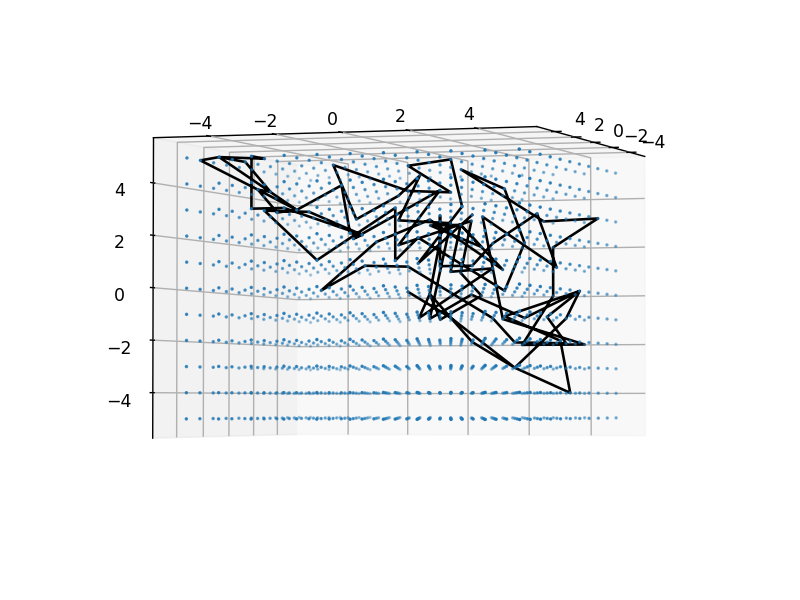

In [6]:
plot_walk(100,extent=2)

## Measuring the mean squared distance

In [7]:
step_positions = random_walk(lims=[-100,100,-100,100,-100,100],nsteps=50)

In [8]:
def mean_squared_distance(step_positions):
    
    separation = np.zeros((len(step_positions)-1,3))
    msd = np.zeros(len(step_positions)-1)
    
    for i,_ in enumerate(step_positions[1:]):
        separation[i] = step_positions[i] - step_positions[0]
        msd[i]= sum(j**2 for j in separation[i])

    return msd

In [9]:
msds=mean_squared_distance(step_positions)

<IPython.core.display.Javascript object>


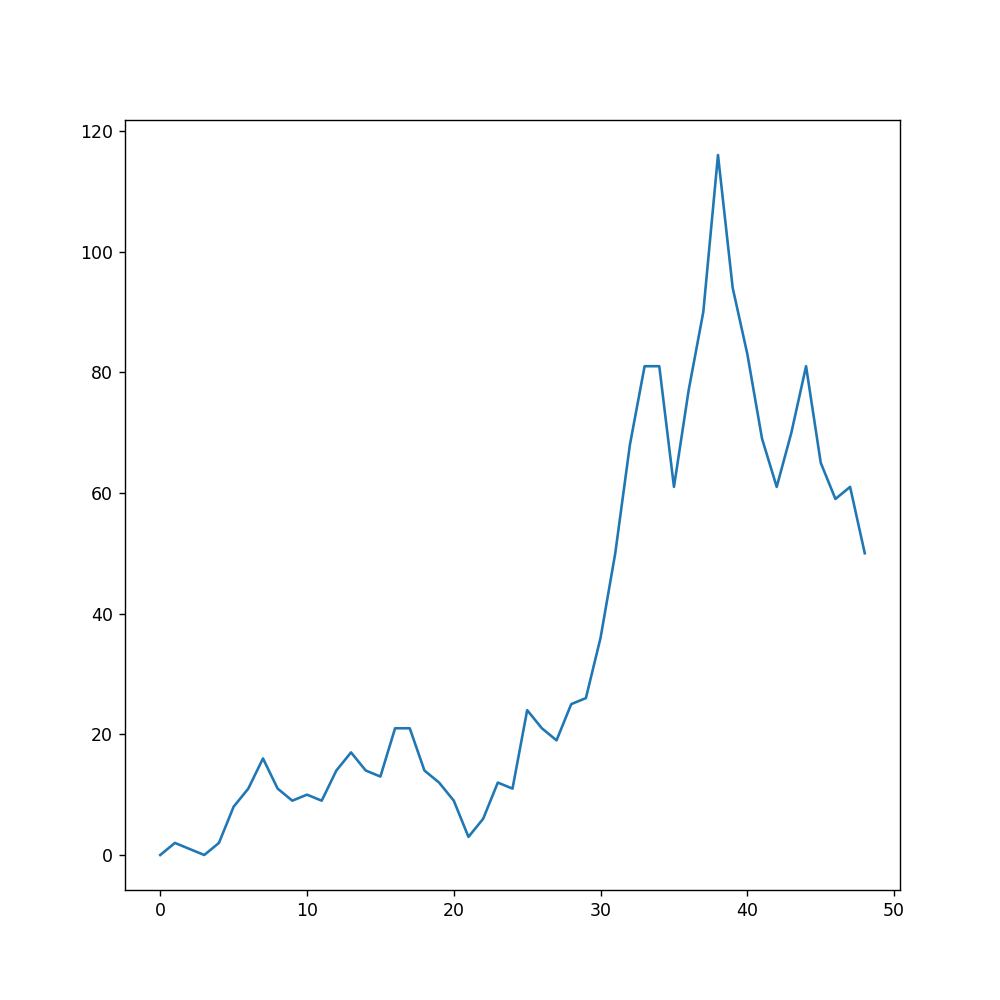

In [10]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(len(msds)),msds)

## 3D Exponential CTRW

In [11]:
def exp_vals(mean_free_path,samples):
    #Streamlined function to only output a single exponentially distributed distance value.
    #Uses the inverse CDF of the relevant exponential distribution.
    
    random_values = np.random.uniform(0,1,size=samples)
    #random value calculated in 0 1 interval, corresponding to the potential values of the CDF
    
    inverse_cdf_values = -mean_free_path*np.log(random_values)
    #inverse CDF used to get the x value
    
    return inverse_cdf_values

def unit_vectors(N):
    #Function produces points distributed evenly over solid angles of the sphere, using ICDFs of the angles, as 
    #opposed to directly distributing over the polar angles
    
    #N is the number of points
    #radius is the desired radius of points
    
    random_value_1 = np.random.uniform(0,1,N)
    random_value_2 = np.random.uniform(0,1,N)
    
    #ICDFs are called
    inclination = np.arccos(1-2*random_value_1)
    azimuth = 2*(np.pi)*random_value_2
    
    #cartesian conversion
    x = np.cos(azimuth)*np.sin(inclination)
    y = np.sin(azimuth)*np.sin(inclination)
    z = np.cos(inclination)
    
    vector_array = np.stack((x,y,z),1)
    #all vectors are stacked together
    
    return(vector_array)

def gen_steps(mean_free_path, nsteps):
    
    steps = np.zeros((nsteps,3))
    step_lengths = exp_vals(mean_free_path, nsteps)
    step_vectors = unit_vectors(nsteps)
    for i in np.arange(nsteps):
        steps[i] = np.multiply(step_lengths[i],step_vectors[i])
    
    return(steps)

def random_walk_3d(mean_free_path, nsteps,init_pos=[0,0,0]):
    
    steps = gen_steps(mean_free_path,nsteps)
    positions = np.zeros((nsteps,3))
    positions[0]=init_pos
    
    for i in np.arange(nsteps-1):
        positions[i+1] = positions[i]+steps[i]
    
    return positions
        

In [12]:
def plot_random_walks(mean_free_path, nwalks, init_pos=[0,0,0],nsteps=100):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in np.arange(nwalks):
        #nsteps = np.random.randint(1,100)
        r_walk_coords = random_walk_3d(1,nsteps)
        ax.plot(r_walk_coords[:,0],r_walk_coords[:,1],r_walk_coords[:,2])
        
    return
        

<IPython.core.display.Javascript object>


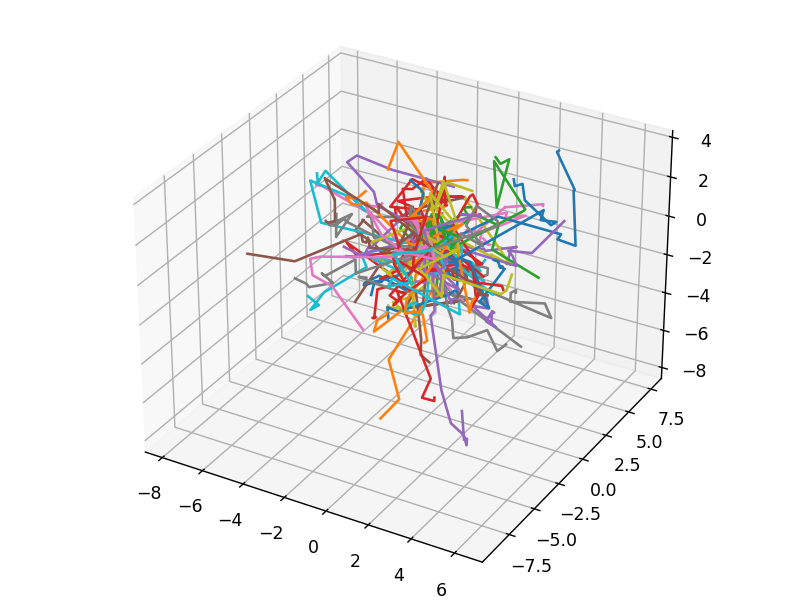

In [13]:
plot_random_walks(1,100,nsteps=10)

In [23]:
def mc_random_walk(nwalks,mean_free_path=1,dim=100,nsteps=20,plot_walks=0,discrete=0):
    
    fig,ax = plt.subplots(figsize=(7,7))
    
    x_vals = np.arange(nsteps-1)
    
    msds_mc = np.zeros((nsteps-1,nwalks))
    
    lims = [-dim,dim,-dim,dim,-dim,dim]
    
    for i in np.arange(nwalks):
        
        if discrete==1:
            step_positions = random_walk(lims=lims,nsteps=nsteps)
        else:
            step_positions = random_walk_3d(mean_free_path,nsteps=nsteps)
            
        
        msds=mean_squared_distance(step_positions)
        msds_mc[:,i] = msds
        
        if plot_walks == 1:
            ax.plot(x_vals,msds)
    
    msds_mean = np.mean(msds_mc,axis=1)
    msds_std = np.std(msds_mc,axis=1)
    
    ax.errorbar(x_vals,msds_mean,yerr=msds_std/np.sqrt(nwalks),fmt='.',color='k',zorder=3)
    
    # linear fit
    coef, cov = np.polyfit(x_vals, msds_mean, 1, cov=True)
    
    ax.plot(x_vals,coef[0]*x_vals+coef[1],label="fit $y=mx+c$")
    plt.xlabel('Step')
    plt.ylabel('$<r^2>$')
    plt.suptitle("Plot of {} vs {}".format('$<r^2>$', 'Step Number'))
    plt.title("{} steps, {} runs".format(nsteps, nwalks))
    plt.annotate(r"$m = {:.5f}\pm{:.5f}$".format(coef[0], np.sqrt(np.diag(cov))[0]), xy=(0.01, 0.9), xycoords='axes fraction')
    plt.annotate(r"$c = {:.5f}\pm{:.5f}$".format(coef[1], np.sqrt(np.diag(cov))[1]), xy=(0.01, 0.85), xycoords='axes fraction')
    plt.legend(loc='upper left')
    
    return
        

<IPython.core.display.Javascript object>


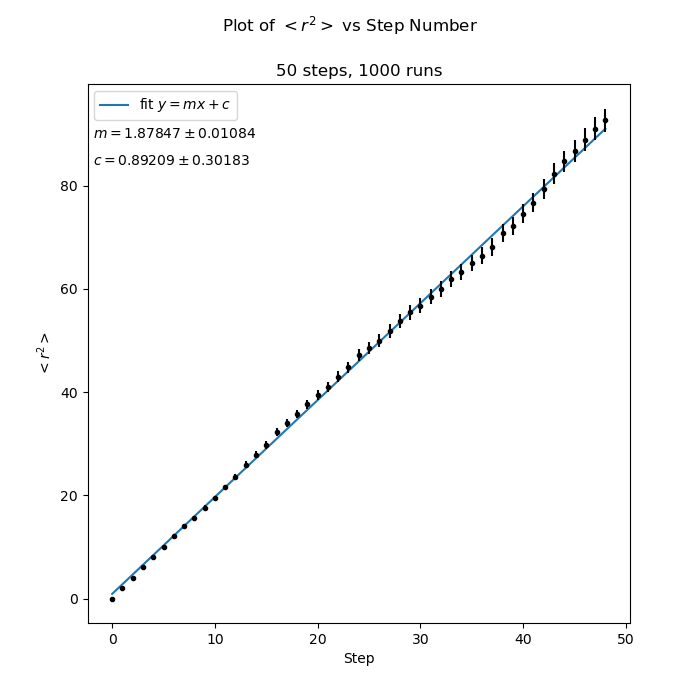

In [24]:
mc_random_walk(1000,dim=100,nsteps=50,plot_walks=0,discrete=1)

<IPython.core.display.Javascript object>


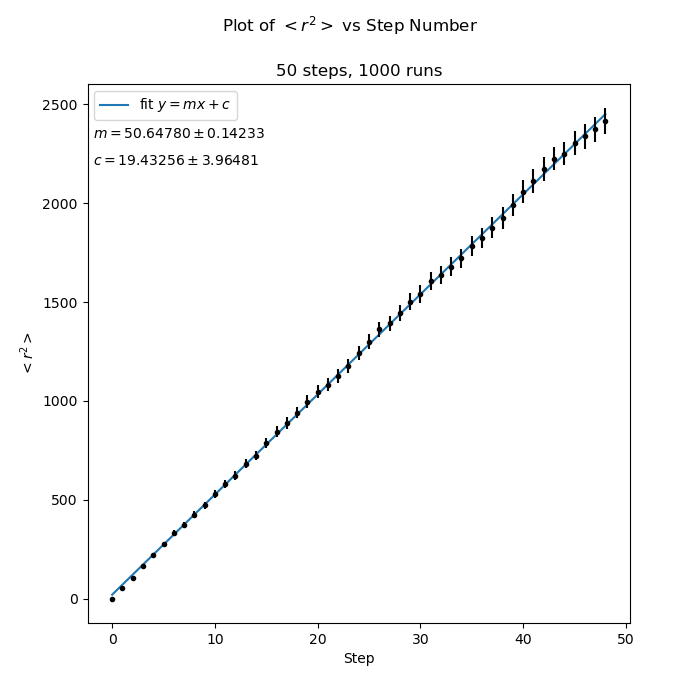

In [26]:
mc_random_walk(1000,mean_free_path=5,nsteps=50,plot_walks=0)

# Extra Code

In [18]:
def gen_obstruction(centroid,size):
    
    positions = np.zeros((size,3))
    positions[0] = centroid
    
    for i in range(size-1):
        if i==0:
            positions[i+1] = positions[0]+gen_step()
        else:
            rand_j = np.random.randint(0,i)
            positions[i+1] = positions[rand_j]+gen_step()
    return(positions)

def plot_obstr(size,centroid,lims=[-5,5,-5,5,-5,5],extent=1):
    
    obstruction=gen_obstruction(centroid,20)
    ii,jj,kk = np.meshgrid(np.arange(lims[0],lims[1]+1,1), 
                           np.arange(lims[2],lims[3]+1,1),
                           np.arange(lims[4],lims[5]+1,1),indexing='ij')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(ii,jj,kk,s=1)
    ax.scatter(obstruction[:,0],obstruction[:,1],obstruction[:,2],c='k')
    plt.show()
    


<IPython.core.display.Javascript object>


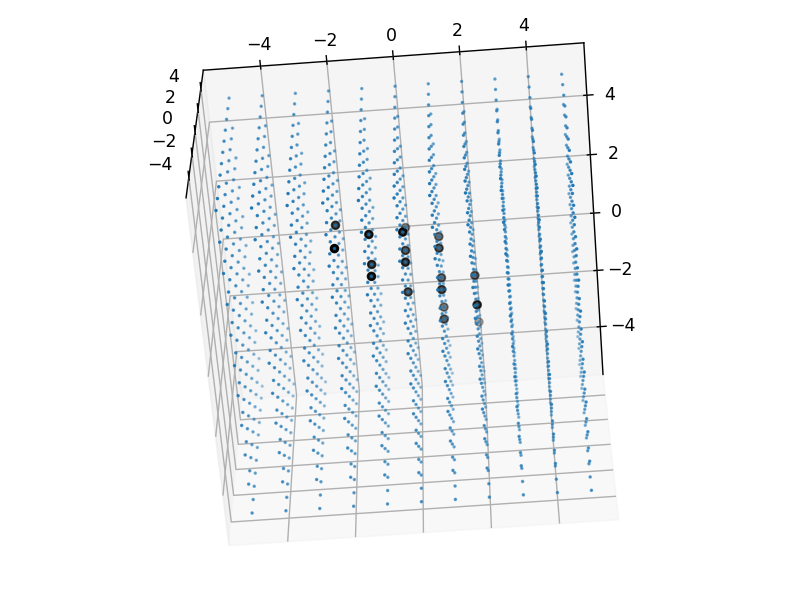

In [20]:
plot_obstr(25,np.array([0,0,0]))